# Common Splits

This notebook is available in Google Colaboratory at https://colab.research.google.com/github/paranal-sw/parlogs-observations/blob/main/notebooks/02-common-splits.ipynb

## Types of splits

The splits of the dataset suggested below are common use cases of Paranal daily work.

1. Combine traces in a single instrument: merge two or more types of traces into a single dataframe
2. By execution state: Filter the traces to those executions that failed or was successful.
3. By Templates: combine traces of same templates
4. All by specific subsystem in a time range: Useful to have an extended dataset focused on one system.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt


## Load Dataset

In [2]:
# PIONIER MATISSE GRAVITY
INSTRUMENT='GRAVITY'
# 1d 1w 1m 6m
RANGE='1w'


In [3]:
from urllib.request import urlretrieve
REPO_URL='https://huggingface.co/datasets/Paranal/parlogs-observations/resolve/main/data'
PATH='sample_data' # Convenient name to be Colab compatible

!mkdir -p $PATH

# Comment what you actually need

fname = f'{INSTRUMENT}-{RANGE}-meta.parket'
if not os.path.exists(f'{PATH}/{fname}'):
    urlretrieve(f'{REPO_URL}/{fname}', f'{PATH}/{fname}')
df_meta=pd.read_parquet(f'{PATH}/{fname}')

fname = f'{INSTRUMENT}-{RANGE}-traces.parket'
if not os.path.exists(f'{PATH}/{fname}'):
    urlretrieve(f'{REPO_URL}/{fname}', f'{PATH}/{fname}')
df_inst=pd.read_parquet(f'{PATH}/{fname}')

fname = f'{INSTRUMENT}-{RANGE}-traces-SUBSYSTEMS.parket'
if not os.path.exists(f'{PATH}/{fname}'):
    urlretrieve(f'{REPO_URL}/{fname}', f'{PATH}/{fname}')
df_subs=pd.read_parquet(f'{PATH}/{fname}')

fname = f'{INSTRUMENT}-{RANGE}-traces-TELESCOPES.parket'
if not os.path.exists(f'{PATH}/{fname}'):
    urlretrieve(f'{REPO_URL}/{fname}', f'{PATH}/{fname}')
df_tele=pd.read_parquet(f'{PATH}/{fname}')

## Single Instrument Traces

Merge two or more types of traces of an instrument into a single dataframe. This step is common in several analysis and is used to characterize the executions of an instrument and how the rest of the systems react.

In [4]:
all_traces = [df_inst, df_subs, df_tele]

df_all = pd.concat(all_traces)
df_all.sort_values('@timestamp', inplace=True)
df_all.reset_index(drop=True, inplace=True)

In [5]:
print(f'Systems in dataframe: {df_all["system"].sort_values().unique()}')

df_all

Systems in dataframe: ['ARAL' 'AT1' 'AT2' 'AT3' 'AT4' 'DL' 'GRAVITY' 'ISS' 'RMNMON' 'RMNREC']


,@timestamp,system,hostname,loghost,logtype,envname,procname,procid,module,keywname,keywvalue,keywmask,logtext,trace_id
0,2019-04-02 02:26:35.908,GRAVITY,wgv,wgv,LOG,wgv,bob_26244,87.0,seq,,,,GRAVITY_single_acq -- GRAVITY Single Mode Acqu...,0
1,2019-04-02 02:26:35.908,GRAVITY,wgv,wgv,LOG,wgv,bob_26244,87.0,seq,,,,Started at 2019-04-02T02:26:35 (underlined),0
2,2019-04-02 02:26:36.000,GRAVITY,wgv,wgv,FLOG,wgv,logManager,0.0,,,,wgv,COMMENT FTOPT LOOP (DB) STOPPED,0
3,2019-04-02 02:26:36.000,GRAVITY,wgv,wgv,FLOG,wgv,logManager,0.0,,,,wgv,COMMENT LONGITUDINAL PUPIL POSITION LOOP STOPPED,0
4,2019-04-02 02:26:36.000,GRAVITY,wgv,wgv,FLOG,wgv,logManager,0.0,,,,wgv,COMMENT FIELD IMAGER LOOP (DB) STOPPED,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841262,2019-04-07 23:57:56.941,GRAVITY,wgv,wgv,ERR,wgv,bob_44144,125.0,seq,,,,PRESET). (red),151
841263,2019-04-07 23:57:56.941,GRAVITY,wgv,wgv,LOG,wgv,bob_44144,125.0,seq,,,,INFO: Stop Coude auto guiding ... (red),151
841264,2019-04-07 23:57:56.941,GRAVITY,wgv,wgv,LOG,wgv,bob_44144,125.0,seq,,,,ERROR performing command SETUP (INFO: Preset t...,151
841265,2019-04-07 23:57:56.941,GRAVITY,wgv,wgv,LOG,wgv,bob_44144,125.0,seq,,,,Finished in 14 seconds at 2019-04-07T23:57:56 ...,151


## By Execution State

There are three posible execution states: 

1. Succesful execution: The template finished normally
2. Manual abort: The operator decided to interrupt the current observation
3. Failed execution: The system reached a critical error that stops the observation automatically

The following combinations of Aborted/ERROR are used to name the execution state:

| Execution State     | Aborted | ERROR |
|-----|-----|-----|
| Failed execution    | False   | True  |
| Failed execution    | True    | True  |
| Manual abort        | True    | False |
| Succesful execution | False   | False |

The general strategy is to filter the df_meta by the desired state and then filter df_all to all trace_ids in the filtered df_meta. The pandas method ```isin()``` is used for this purpose.

### Succesful executions

Some analysis requires to measure the normal flow of event logs. This can be obtained from the successful executions. Aborted=False is a sufficient condition.

In [6]:
df_meta_success = df_meta[ (df_meta['Aborted']==False) & (df_meta['ERROR']==False) ]
df_all_success  = df_all [ df_all['trace_id'].isin(df_meta_success.index.values) ]

print(f'df_meta has {len(df_meta_success)} successful executions of {len(df_meta)} in total.')
print(f'From {len(df_all)} events in the combined traces, {len(df_all_success)} corresponds to successful executions.')
print(f'The combined traces contains {len(df_all_success["trace_id"].unique())} unique trace_ids.')

df_meta has 121 successful executions of 152 in total.
From 841267 events in the combined traces, 658389 corresponds to successful executions.
The combined traces contains 121 unique trace_ids.


### Failed executions

This split is useful to analyse the errors that could lead to a failed execution. It is enough to filter by ERROR=True.

In [7]:
df_meta_failed = df_meta[ df_meta['ERROR']==True ]
df_all_failed  = df_all [ df_all['trace_id'].isin(df_meta_failed.index.values) ]

print(f'df_meta has {len(df_meta_failed)} failed executions of {len(df_meta)} in total.')
print(f'From {len(df_all)} events in the combined traces, {len(df_all_failed)} corresponds to failed executions.')
print(f'The combined traces contains {len(df_all_failed["trace_id"].unique())} unique trace_ids.')

df_meta has 24 failed executions of 152 in total.
From 841267 events in the combined traces, 149898 corresponds to failed executions.
The combined traces contains 24 unique trace_ids.


### Manual Aborts

Excercise left to the reader

## Group by Templates

A Template in the context of VLT executions corresponds to a script file run in "BOB", the Broker of Observations, that receive an array of parameters and executes high level tasks by calling the API of lower level processes. The exact behavior of a template may vary with the parameters, for example in some instruments using filter RED  lead to different path in the code than use the filter BLUE, but in general the execution of a single template is rather deterministic. Therefore it makes sense to characterize the behavior of each templates to find deviations from the expected path(s) of execution(s).

In [8]:
# Build a dict of {TPL_ID: traces}
df_traces_by_TPL = {}
for TPL_ID in df_meta['TPL_ID'].unique():
    indices = df_meta[ df_meta['TPL_ID']==TPL_ID ].index
    df_traces_by_TPL[TPL_ID] = df_all [ df_all['trace_id'].isin(indices) ]

In [9]:
# Average events per TPL_ID execution
for TPL_ID, df in df_traces_by_TPL.items():
    print (f'{TPL_ID:<30} : {len(df)/len(df["trace_id"].unique()):<8.0f} average events')

GRAVITY                        : 4178     average events
GRAVITY_single_acq             : 3384     average events
GRAVITY_single_obs_calibrator  : 2531     average events
GRAVITY_dual_acq               : 7988     average events
GRAVITY_dual_obs_exp           : 4224     average events
GRAVITY_dual_obs_swap          : 13214    average events
GRAVITY_gen_cal_init           : 7231     average events
GRAVITY_gen_cal_p2vm           : 13635    average events
P2VMWAVESC                     : 14395    average events
GRAVITY_gen_cal_dark           : 3315     average events
GRAVITY_gen_cal_standby        : 186      average events
GRAVITY_gen_tec_checkFddl      : 1518     average events
GRAVITY_gen_tec_checkMetZero   : 10692    average events
GRAVITY_gen_tec_AcqFibAOnAxis  : 1961     average events
GRAVITY_gen_tec_AcqFibA        : 1740     average events
GRAVITY_gen_tec_AcqFibB        : 7602     average events
GRAVITY_gen_tec_RoofPos        : 119      average events
GRAVITY_gen_tec_PTref          

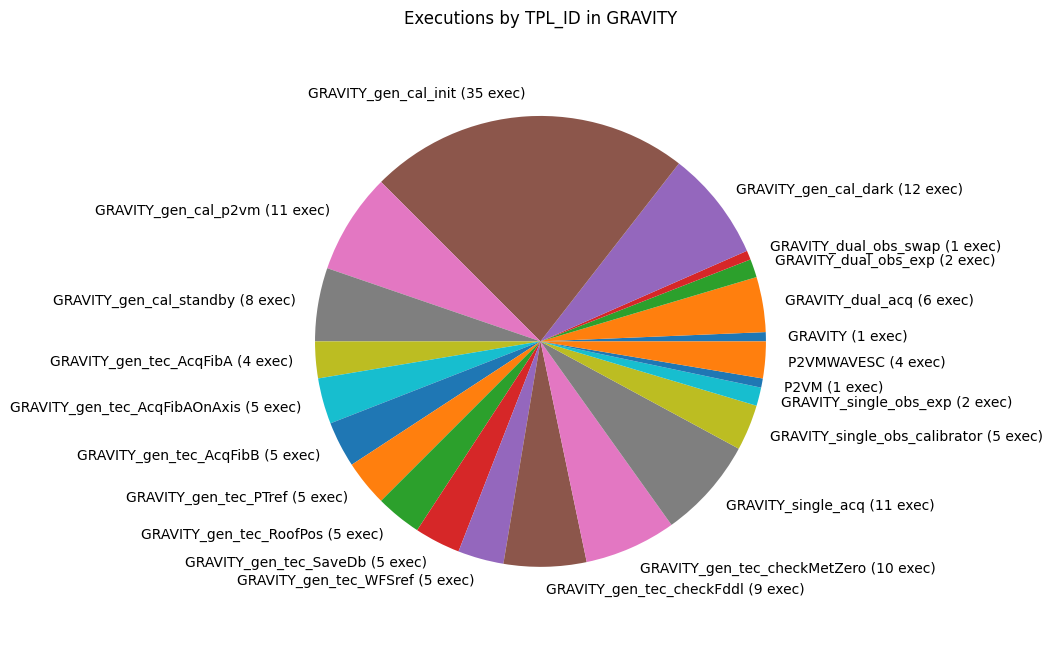

In [10]:
# Graph the number of executions per TPL_ID

TPL_ID_list = sorted(df_traces_by_TPL.keys())
data = [ len(df_traces_by_TPL[TPL]['trace_id'].unique()) for TPL in TPL_ID_list]
labels = [ f'{TPL_ID_list[i]} ({data[i]} exec)' for i in range(len(TPL_ID_list)) ]

plt.pie(data, labels=labels, radius=0.2)
plt.title(f"Executions by TPL_ID in {INSTRUMENT}")
plt.axis('equal')  
plt.subplots_adjust(top=1.4)
plt.rcParams['font.size'] = 9
plt.show()

## All by specific subsystem

Sometimes it is useful to have several event logs of a single subsystem to study, for example, the frequency of specific events and determine its rarity. This split provides an extended dataset.

The possibilites are DL, ISS, RMNREC, RMNMON, ARAL. Let's see an example with subsystem=DL. 

In [11]:
subsys = 'DL'

We need the metadata per instrument so later we can do more filtering if needed, for example by ERR or TPL_ID.

In [12]:
# Download the traces and metadata

# Defined in the top of the notebook
#RANGE = '1w'

df_meta_by_subsys = {}
df_traces_by_subsys_and_inst = {}

for inst in ['GRAVITY', 'MATISSE', 'PIONIER']:

    # Metadata per instrument
    fname = f'{inst}-{RANGE}-meta.parket'
    if not os.path.exists(f'{PATH}/{fname}'):
        urlretrieve(f'{REPO_URL}/{fname}', f'{PATH}/{fname}')
    df_meta_by_subsys[inst]=pd.read_parquet(f'{PATH}/{fname}')

    # Traces for all subsystems
    fname = f'{inst}-{RANGE}-traces-SUBSYSTEMS.parket'
    if not os.path.exists(f'{PATH}/{fname}'):
        urlretrieve(f'{REPO_URL}/{fname}', f'{PATH}/{fname}')
    df=pd.read_parquet(f'{PATH}/{fname}')

    # Add instrument to be able fo filter by ['instrument', 'trace_id']
    df['instrument'] = inst

    # Filter traces to selected subsystem
    df_traces_by_subsys_and_inst[inst] = df[df['system']==subsys]

# Combine all
df_traces_by_subsys = pd.concat(df_traces_by_subsys_and_inst)
df_traces_by_subsys.sort_values('@timestamp', inplace=True)
df_traces_by_subsys.reset_index(drop=True, inplace=True)

In [13]:
print(f'Meta data available for {df_meta_by_subsys.keys()}')
print(f'Unique systems in {subsys} traces: {df_traces_by_subsys["system"].unique()}')
print(f'Unique instrument in {subsys} traces: {df_traces_by_subsys["instrument"].unique()}')

df_traces_by_subsys

Meta data available for dict_keys(['GRAVITY', 'MATISSE', 'PIONIER'])
Unique systems in DL traces: ['DL']
Unique instrument in DL traces: ['MATISSE' 'GRAVITY' 'PIONIER']


,@timestamp,system,hostname,loghost,logtype,envname,procname,procid,module,keywname,keywvalue,keywmask,logtext,trace_id,instrument
0,2019-04-02 01:30:02.000,DL,wdline,wdline,LOG,none,logBackupUtil,0.0,UNIX,,,,Clean Logs : group vlt hour 12 max. size 30000000,0,MATISSE
1,2019-04-02 01:30:17.677,DL,wdline,wdline,LOG,wdline,dlprsControl,23.0,dlprs,,,,"PRESET: Received command: CLRSTP, Buffer:",0,MATISSE
2,2019-04-02 01:30:17.677,DL,wdline,wdline,LOG,wdline,dlifControl,124.0,tif,,,,"TIF : Received command: CLRSTP, Buffer:",0,MATISSE
3,2019-04-02 01:30:17.681,DL,wdline,wdline,LOG,wdline,dlprsControl,23.0,dlprs,,,,PRESET: Command CLRSTP (NoMove) succesfully co...,0,MATISSE
4,2019-04-02 01:30:17.681,DL,wdline,wdline,LOG,wdline,dlifControl,124.0,tif,,,,"TIF : Succesfully completed command: CLRSTP,...",0,MATISSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75827,2019-04-07 23:57:51.603,DL,wdline,wdline,LOG,wdline,dltrjControl_6,123.0,dltrj,,,,CalcCB: have to invert the pointing model,151,GRAVITY
75828,2019-04-07 23:57:54.856,DL,wdline,wdline,LOG,wdline,dlifControl,124.0,tif,,,,"TIF : Received command: CLRSTP, Buffer:",151,GRAVITY
75829,2019-04-07 23:57:54.856,DL,wdline,wdline,LOG,wdline,dlprsControl,23.0,dlprs,,,,"PRESET: Received command: CLRSTP, Buffer:",151,GRAVITY
75830,2019-04-07 23:57:54.860,DL,wdline,wdline,LOG,wdline,dlprsControl,23.0,dlprs,,,,PRESET: Command CLRSTP (NoMove) succesfully co...,151,GRAVITY
